# Solution

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install igraph
!pip install python-igraph==0.9.6
# !pip install pipwin
# !pipwin install cairocffi
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-igraph: filename=python_igraph-0.9.6-cp310-cp310-linux_x86_64.whl size=2555581 sha256=3cd3362280623ce4255cea88d2b6ff70729cb120f34c1d2fbc7f31215ebbae46
  Stored in directory: /root/.cache/pip/wheels/ef/14/e6/4f7a42ad0b6bbf5eb65c6358c608065dd3646c2c3b01561e84
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 4.3 MB/s eta 0:00:00


In [3]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
from copy import deepcopy

In [4]:
random.seed(2022)
np.random.seed(2022)

In [5]:
file_geo = "/content/drive/MyDrive/los_angeles_censustracts.json"
file_time = "/content/drive/MyDrive/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"

#file_geo = "/content/drive/MyDrive/Colab Notebooks/los_angeles_censustracts.json"
#file_time = "/content/drive/MyDrive/Colab Notebooks/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"

# file_geo = "los_angeles_censustracts.json"
# file_time = "los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"

with open(file_geo) as f:
    census_tracts = json.loads(f.readline())

In [6]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [7]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [8]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [ ]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [ ]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open(file_time) as f:
    f.readline()  # skip the first line

    while True:
        line = f.readline()
        if line == '':
            break  # end of file

        vals = line.strip().split(',')

        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue

        edges.append((src - 1, dest - 1))
        weights.append(dist)

In [ ]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [ ]:
print(len(g.vs), len(g.es))

In [ ]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

### QUESTION 9

In [ ]:
print("number of nodes: ", len(g.vs))
print("number of edges: ", len(g.es))

In [ ]:
mst = g.spanning_tree(weights=g.es['weight'])

In [ ]:
edf = mst.get_edge_dataframe()
edf.head()

In [ ]:
import matplotlib.pyplot as plt
weights = mst.es['weight']
binwidth = 20
bins = np.arange(min(weights), max(weights) + binwidth, binwidth)
plt.hist(weights, bins=bins)
plt.show()

### QUESTION 10

In [ ]:
# !pip install geopy

In [ ]:
from geopy.geocoders import Nominatim

# Function to get street address near a location given its latitude and longitude
def get_street_address(lat, lon):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.address
    return None

num_edges_to_report = 5

# Convert EdgeView to list and slice
edges_to_report = list(mst.vs)[:num_edges_to_report]

for i, e in enumerate(mst.es):
    source_centroid = mst.vs[e.source]['coordinates']
    target_centroid =  mst.vs[e.target]['coordinates']
    source_address = get_street_address(source_centroid[1], source_centroid[0])
    target_address = get_street_address(target_centroid[1], target_centroid[0])

    print("Edge: ", e.source, e.target)
    print("Source Address:", source_address)
    print("Target Address:", target_address)
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n---------\n'.format(linalg.norm(mst.vs[e.source]['coordinates'] - mst.vs[e.target]['coordinates'])* 69, e['weight']))
    print()
    if i > 10:
        break

# TSP Approximation

### QUESTION 11: Check Traingle Inequality

In [ ]:
def is_triangle(sides):
    sides.sort()
    return sides[0] + sides[1] > sides[2]

print('Test:', is_triangle([1,4,2]), is_triangle([3,5,3]))

In [ ]:
def sample_triangles(g, n_samples):
    result = []
    all_vertices = list(g.vs)
    num_vertices = len(all_vertices)

    i = 0
    while i < n_samples:
        triangle_vs = random.sample(all_vertices, 3)
        triangle_ids = [v.index for v in triangle_vs]
        s = 0
        for k in range(3):
            for j in range(k):
                edge = g.get_eid(triangle_ids[k], triangle_ids[j], directed=False, error=False)
                if edge != -1:
                    s += 1
        if s == 3:
            result.append(tuple(triangle_ids))
            i += 1

    return result

In [ ]:
n_samples = 1000  # WARNING: this might take a minute for larger sample sizes
triangles = 0
sets_that_have_3_edges = 0
sampled = sample_triangles(g, n_samples)
for triangle_vs in sampled:

    edge_lengths = []

    for i in range(3):
        for j in range(i):
            edge_lengths.append(min(g.es.select(_between=([triangle_vs[i]], [triangle_vs[j]]))['weight']))

    triangles += is_triangle(edge_lengths)

print('Triangle inequality holds by {}%.'.format(round(100.0 * triangles / n_samples, 1)))

### QUESTION 12

### Preorder Traversal Demo

In [ ]:
def preorder_traversal(root, root_parent=None):
    result = [root]

    neighbors = root.neighbors()
    if root_parent is not None:
        neighbors.remove(root_parent)

    for neighbor in neighbors:
        result.extend(preorder_traversal(neighbor, root))
    return result

In [ ]:
t = Graph.Tree(20, 3)

visual_style = {}
visual_style["vertex_color"] = 'yellow'
visual_style["vertex_label"] = [v.index for v in t.vs]
visual_style["vertex_label_color"] = 'blue'
visual_style["bbox"] = (200, 200)

plot(t, **visual_style)

In [ ]:
print([v.index for v in preorder_traversal(t.vs[0])])

### Actual Data

In [ ]:
def find_eulerian_tour(graph):
    tour = []
    stack = [0]  # Start from vertex 0 (or any arbitrary vertex)

    while stack:
        v = stack[-1]

        if graph.degree(v) == 0:
            tour.append(v)
            stack.pop()
        else:
            u = graph.neighbors(v)[0]  # Take the first neighbor of v
            stack.append(u)
            graph.delete_edges([(v, u)])

    return tour[::-1]  # Reverse the tour to get the correct order

In [ ]:
# Create a new graph
vertex_ids = {v: i for i, v in enumerate(mst.vs)}
# multigraph = Graph()
multigraph = Graph(directed=True)
multigraph.add_vertices(len(vertex_ids))

for edge in mst.es:
    source, target = edge.source, edge.target
    multigraph.add_edges([(source, target), (target, source)])

In [ ]:
euler_tour = find_eulerian_tour(multigraph)

# tour_sequence = preorder_traversal(mst.vs[euler_tour[0]])
tour_sequence = []
visited = set()
for node in euler_tour:
    if node not in visited:
        tour_sequence.append(node)
        visited.add(node)

tsp = tour_sequence[:-1]  # Remove the duplicate final node
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

### Measureing Relative Performance Guarantee

In [ ]:
mst_cost = sum(mst.es['weight'])
hop_distances = []
for i in range(len(tsp) - 1):
    edge_index = g.get_eid(tsp[i], tsp[i + 1], directed=False, error=False)
    hop_distances.append(g.es[edge_index]['weight'])

print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances]))

In [ ]:
tsp_cost = sum(hop_distances)
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

### QUESTION 13

In [ ]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()

## Question 15
Max Capacity =• Each degree of latitude and longitude ≈ 69 miles
• Car length ≈ 5 m = 0.003 mile
• Cars maintain a safety distance of 2 seconds to the next car
• Each road has 2 lanes in each direction

2v/(.003+v/`1800)


##Question 14/16

In [9]:
import numpy as np
import json
from scipy.spatial import Delaunay
from igraph import Graph

lat_long = {}

with open(file_geo, 'r') as f:
    d = json.load(f)
    features = d['features']

    for feature in features:
        latitude = 0.0
        longitude = 0.0

        geometry_type = feature['geometry']['type']
        coordinates = np.array(feature['geometry']['coordinates'][0]) if geometry_type == 'Polygon' else np.array(
            feature['geometry']['coordinates'][0][0])

        for coordinate in coordinates:
            latitude += coordinate[1]
            longitude += coordinate[0]

        latitude /= len(coordinates)
        longitude /= len(coordinates)

        movement_id = feature['properties']['MOVEMENT_ID']
        display_name = feature['properties']['DISPLAY_NAME']

        lat_long[movement_id] = (display_name, latitude, longitude)

lat = []
lon = []
for i in range(1, len(lat_long) + 1):
    lat.append(lat_long[str(i)][1])
    lon.append(lat_long[str(i)][2])

lat_lon = tuple(zip(lat, lon))
delaunay_out = Delaunay(lat_lon)

edges = delaunay_out.simplices
g_del = Graph.TupleList(edges, directed=False, vertex_name_attr='name')

f.close()

Max Capacity =• Each degree of latitude and longitude ≈ 69 miles
• Car length ≈ 5 m = 0.003 mile
• Cars maintain a safety distance of 2 seconds to the next car
• Each road has 2 lanes in each direction

2v/(.003+v/`1800)


In [10]:
malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
max_cars=2*velocity/(.003+velocity/1800)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

deg_dist_mal = g_del.degree(malibu_node,mode='out')
deg_dist_lb = g_del.degree(long_beach_node,mode='in')
paths = g_del.adhesion(long_beach_node,malibu_node)

In [11]:
print(max_cars)
print(deg_dist_mal )
print(deg_dist_lb)
print(paths)

3214.3687557752646
4
5
4


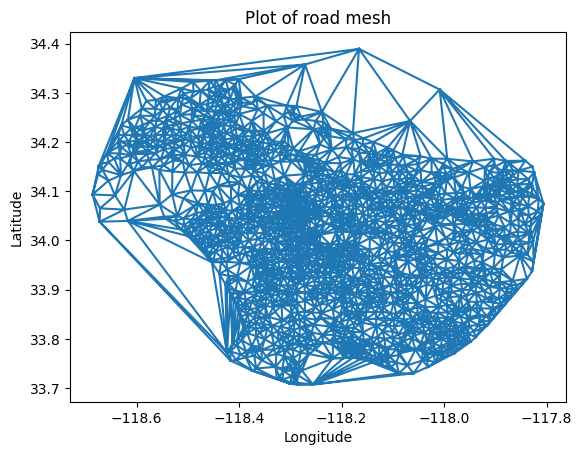

In [12]:

plt.triplot(lon, lat, delaunay_out.simplices)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of road mesh')
plt.show()

## Question 17

In [13]:
g_temp = Graph()
g_temp.add_vertices(len(delaunay_out.points))

# Set vertex attributes for latitude and longitude
g_temp.vs['lat'] = lat
g_temp.vs['lon'] = lon

coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence

fake_edges = set()

for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp.add_edge(edge[0], edge[1])
        else:
            fake_edges.add(edge)
#g_temp.delete_edges(fake_edges)

In [14]:
thresh_plot = []
for simplex in delaunay_out.simplices:
    found_edge = False
    for edge in fake_edges:
        vertex1, vertex2 = edge
        if vertex1 in simplex and vertex2 in simplex:
            found_edge = True
            break

    if not found_edge:
        thresh_plot.append(simplex)

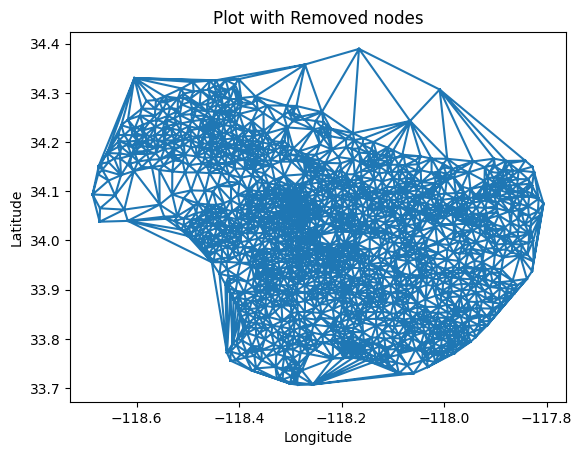

In [15]:
plt.triplot(lon, lat, thresh_plot)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with Removed nodes')
plt.show()

In [16]:
for ind in fake_edges:
  g_temp.delete_edges(ind)

In [17]:
type(thresh_plot)

list

## Q 18 relies on 13

In [ ]:
# malibu= [34.026, -118.78]
# long_beach =  [33.77, -118.18]
# velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
# max_cars=2*velocity/(.003+velocity/1800)

# min_long_beach=np.inf
# min_malibu=np.inf
# long_beach_node=0
# malibu_node=0
# for i in range(1,len(lat_lon)):
#     long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
#     malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
#     if long_beach_closest<min_long_beach:
#         min_long_beach=long_beach_closest
#         long_beach_node=i
#     if malibu_closest<min_malibu:
#         min_malibu=malibu_closest
#         malibu_node=i

# deg_dist_mal = g_del.degree(malibu_node,mode='out')
# deg_dist_lb = g_del.degree(long_beach_node,mode='in')
# paths = g_del.adhesion(long_beach_node,malibu_node)

In [ ]:
print(g_temp.adhesion(long_beach_node,malibu_node)-1)
print(g_temp.degree(malibu_node,mode='out')-1)
print(g_temp.degree(long_beach_node,mode='in')-1)

In [19]:
malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
max_cars=2*velocity/(.003+velocity/1800)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

deg_dist_mal = g_del.degree(malibu_node,mode='out')
deg_dist_lb = g_del.degree(long_beach_node,mode='in')
paths = g_del.adhesion(long_beach_node,malibu_node)

In [26]:
print(max_cars)
print(paths)
print(deg_dist_mal)

3214.3687557752646
4
4


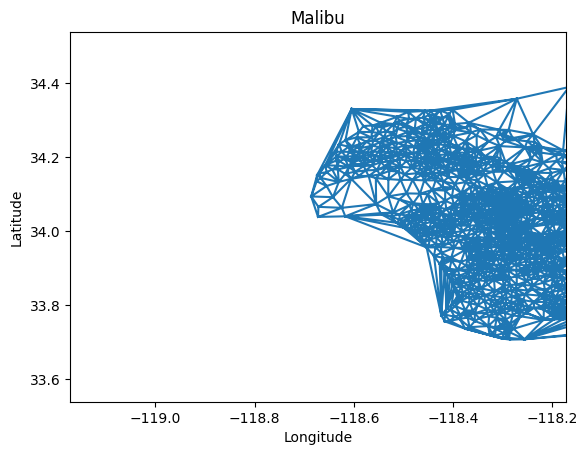

In [23]:
plt.triplot(lon, lat, thresh_plot)
plt.ylim(lat_lon[malibu_node][0]-.5,lat_lon[malibu_node][0]+.5)
plt.xlim(lat_lon[malibu_node][1]-.5,lat_lon[malibu_node][1]+.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Malibu')
plt.plot(lon[malibu_node], lat[malibu_node])

## Q 19

In [ ]:
import numpy as np
import igraph as ig
from itertools import combinations
from operator import itemgetter

def calculate_euclidean_distance(v1, v2):
    return np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)

def calculate_extra_distance(v1, v2):
    shortest_distance = g_temp.shortest_paths_dijkstra(source=v1.index, target=v2.index, weights='weight')[0][0]
    euclidean_distance = calculate_euclidean_distance(v1, v2)
    extra_distance = shortest_distance - euclidean_distance
    return extra_distance

g_temp = ig.Graph()
g_temp.add_vertices(len(delaunay_out.points))

g_temp.vs['lat'] = lat
g_temp.vs['lon'] = lon

# Add edges to the graph based on coordinate threshold
coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence
for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp.add_edge(edge[0], edge[1], weight=distance)

# Calculate extra distance between all pairs of points
extra_distances = []
vertices = g_temp.vs()
for v1, v2 in combinations(vertices, 2):
    extra_distance = calculate_extra_distance(v1, v2)
    extra_distances.append((v1.index, v2.index, extra_distance))

# Sort the extra distances in descending order
extra_distances_sorted = extra_distances.copy()
extra_distances_sorted.sort(key=itemgetter(2), reverse=True)

# Get the top 20 pairs with highest extra distance
top_pairs = extra_distances_sorted[:20]

# Print the source and destination of the top pairs
for pair in top_pairs:
    source = vertices[pair[0]]
    destination = vertices[pair[1]]
    print(f"Source: ({source['lat']}, {source['lon']}), Destination: ({destination['lat']}, {destination['lon']})")

# Create new edges in the graph for the top pairs
for pair in top_pairs:
    source_index = pair[0]
    destination_index = pair[1]
    g_temp.add_edge(source_index, destination_index)

# Plot the resultant graph on actual coordinates
layout = g_temp.layout_auto()
visual_style = dict(layout=layout, vertex_size=10)
ig.plot(g_temp, **visual_style)

In [ ]:
x = g_temp.vs['lon']
y = g_temp.vs['lat']

# Plot the graph nodes
plt.scatter(x, y, color='blue', label='Existing Nodes')
top_edges = [(pair[0], pair[1]) for pair in top_pairs]

# Plot the new edges
for k, edge in enumerate(top_edges):
    print(f"Source: {edge[0]}, Destination: {edge[1]}, weight: {top_pairs[k][2]}")
    v1_x, v1_y = x[edge[0]], y[edge[0]]
    v2_x, v2_y = x[edge[1]], y[edge[1]]
    plt.plot([v1_x, v2_x], [v1_y, v2_y], color='red', linestyle='dashed', linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network with New Edges')
plt.legend()
plt.show()

In [ ]:
import json
from time import time
from itertools import combinations
from operator import itemgetter
from tqdm import tqdm
import numpy as np
from scipy.spatial import Delaunay
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
COORDINATE_THRESHOLD = 19.2 / 69  # Distance threshold for edge existence
DISTANCE_FACTOR = 100000  # Factor to multiply distance by to get integer weights
MAX_COORDINATE_VALUE = int(COORDINATE_THRESHOLD * DISTANCE_FACTOR)
N_VERTEX = 2716 # found from a previous run of len(g.vs)


file_geo = "./data/los_angeles_censustracts.json"
file_time = "./data/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"


lat_long = np.empty((N_VERTEX, 2), dtype=float)
with open(file_geo, 'r') as f:
    d = json.load(f)
    features = d['features']

    for feature in features:
        geometry_type = feature['geometry']['type']
        centroid = np.array(feature['geometry']['coordinates'][0]) if geometry_type == 'Polygon' else np.array(
            feature['geometry']['coordinates'][0][0])

        movement_id = feature['properties']['MOVEMENT_ID']
        lat_long[int(movement_id) - 1] = centroid.mean(axis=0)[::-1]

delaunay_out = Delaunay(lat_long)
edges = delaunay_out.simplices


g_temp = ig.Graph()
g_temp.add_vertices(len(delaunay_out.points))

g_temp.vs['lat'] = lat_long[:, 0]
g_temp.vs['lon'] = lat_long[:, 1]

# Add edges to the graph based on coordinate threshold
for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < COORDINATE_THRESHOLD:
            g_temp.add_edge(edge[0], edge[1], weight=distance)

In [ ]:
from queue import PriorityQueue

class Dijkstra:

    DISTANCE_FACTOR = 100000  # Factor to multiply distance by to get integer weights

    def __init__(self, g: ig.Graph, n_vertices: int):
        dtype = np.int32
        self._n_vertices = n_vertices
        self._dist = np.empty(n_vertices, dtype=dtype)
        self._q = PriorityQueue()
        self.dist_matrix = np.ones((n_vertices, n_vertices), dtype=dtype) * 2 * MAX_COORDINATE_VALUE

        # Create adjacency matrix
        self._adj = np.ones((n_vertices, n_vertices), dtype=dtype) * 2 * MAX_COORDINATE_VALUE
        self._neigbhors = [[] for _ in range(n_vertices)]
        for u in range(n_vertices):
            for v in g.neighbors(u):
                self._neigbhors[u].append(v)
                val = int(g.es[g.get_eid(u, v)]['weight']*DISTANCE_FACTOR)
                self._adj[u, v] = val
                self._adj[v, u] = val

    def run(self, source: int) -> np.ndarray:
        """Run Dijkstra's algorithm on a graph

        Parameters
        ----------
        source: int
            vertex node (0-indexed)

        Returns
        -------
        shortest_distances: np.ndarray
            Array of shortest distances from source to all other vertices
        """
        # Initialize
        self._dist.fill(2 * MAX_COORDINATE_VALUE)
        self._dist[source] = 0
        for v in range(self._n_vertices):
            self._q.put((self._dist[v], v))

        # Run Dijkstra
        while not self._q.empty():
            _, u = self._q.get()

            for v in self._neigbhors[u]:
                alt = self._dist[u] + self._adj[u, v]
                if alt < self._dist[v]:
                    self.dist_matrix[source, v] = alt
                    self.dist_matrix[v, source] = alt
                    self._dist[v] = alt
                    self._q.put((alt, v))

        self._dist[source] = 2 * MAX_COORDINATE_VALUE
        return self._dist / DISTANCE_FACTOR


dijkstra = Dijkstra(g_temp, n_vertices=N_VERTEX)

In [ ]:
distances = np.empty((N_VERTEX, N_VERTEX), dtype=np.float32)
for i in tqdm(range(N_VERTEX)):
    distances[i] = dijkstra.run(source=i)

In [ ]:
# Calculate extra distance between all pairs of points
extra_distances = []
vertices = g_temp.vs()
for v1, v2 in combinations(vertices, 2):
    dijkstra_dist = distances[v1.index, v2.index]
    euclidean_distance = np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)
    euclidean_distance = euclidean_distance
    extra_distance = dijkstra_dist - euclidean_distance
    extra_distances.append((v1.index, v2.index, extra_distance))

In [ ]:
# Get the top 20 pairs with the highest extra distance
extra_distances.sort(key=itemgetter(2), reverse=True)
top_pairs = extra_distances[:20]

# Print the source and destination of the top pairs
for pair in top_pairs:
    source = vertices[pair[0]]
    destination = vertices[pair[1]]
    # print(f"Source: ({source['lat']}, {source['lon']}), Destination: ({destination['lat']}, {destination['lon']})")

# Create new edges in the graph for the top pairs
for pair in top_pairs:
    source_index = pair[0]
    destination_index = pair[1]
    g_temp.add_edge(source_index, destination_index)

# Plot the graph
lon_coords = g_temp.vs['lon']
lat_coords = g_temp.vs['lat']
new_edges = []
fig = go.Figure()
for i, edge in enumerate(top_pairs):
    x1, y1 = lon_coords[edge[0]], lat_coords[edge[0]]
    x2, y2 = lon_coords[edge[1]], lat_coords[edge[1]]
    fig.add_trace(go.Scattermapbox(
        mode = "lines",
        lon = [x1, x2],
        lat = [y1, y2],
        marker = {'size': 10}
    ))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': -118.2437, 'lat': 34.0522},
        'style': "stamen-terrain",
        'zoom': 8}
)

fig.show()

## QUESTION 20

In [ ]:
# g_temp_2 = g_temp
g_temp_2 = Graph()
g_temp_2.add_vertices(len(delaunay_out.points))

# Set vertex attributes for latitude and longitude
g_temp_2.vs['lat'] = lat
g_temp_2.vs['lon'] = lon

coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence

fake_edges = set()

for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp_2.vs[edge[0]]
        v2 = g_temp_2.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp_2.add_edge(edge[0], edge[1], weight=distance)
        else:
            fake_edges.add(edge)


#g_temp.delete_edges(fake_edges)

In [ ]:
for ind in fake_edges:
  g_temp_2.delete_edges(ind)

In [ ]:
import random
import numpy as np

# Generate random frequencies between 1 and 1000 for each pair of points
frequencies = {}
for v in range(len(lat)):
    for s in range(v + 1, len(lat)):
        frequencies[(v, s)] = random.randint(1, 1000)

# Calculate the weighted extra distance for each pair of points
weighted_extra_distances = []

vertices = g_temp_2.vs()
for k, pair in enumerate(combinations(vertices, 2)):
    v1, v2 = pair
    frequency = frequencies[(v1.index, v2.index)]
    extra_distance = extra_distances[k]#[2]   #change this to [k][2] if needed
    weighted_extra_distance = extra_distance * frequency
    weighted_extra_distances.append(((v1.index, v2.index), weighted_extra_distance))

# Sort the weighted extra distances in descending order and select the top 20 pairs
top_weighted_pairs = sorted(weighted_extra_distances, key=lambda x: x[1], reverse=True)[:20]

# Print the source and destination of the top weighted pairs
for pair, weighted_distance in top_weighted_pairs:
    v, s = pair[0], pair[1]
    print(f"Source: {v}, Destination: {s}, Weight: {weighted_distance}")

# Create the new edges in the graph
new_edges=[]
for pair, _ in top_weighted_pairs:
    v, s = pair[0], pair[1]
    g_temp_2.add_edge(v, s)
    new_edges.append((pair[0],pair[1]))

# Plot the resultant graph on actual coordinates as before
# plt.figure(figsize=(10, 10))
plt.scatter(lon, lat, color='blue', label='Existing Nodes')

for edge in new_edges:
    v1 = edge[0]
    v2 = edge[1]
    plt.plot([lon[v1], lon[v2]], [lat[v1], lat[v2]], color='red', linestyle='dashed',linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network of LA with 20 New Roads')
plt.show()

## QUESTION 21

In [ ]:
g_temp_3 = Graph()
g_temp_3.add_vertices(len(delaunay_out.points))

# Set vertex attributes for latitude and longitude
g_temp_3.vs['lat'] = lat
g_temp_3.vs['lon'] = lon

coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence

fake_edges = set()

for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp_3.vs[edge[0]]
        v2 = g_temp_3.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp_3.add_edge(edge[0], edge[1], weight=distance)
        else:
            fake_edges.add(edge)


for ind in fake_edges:
  g_temp_3.delete_edges(ind)

0
 99.96%
Extra distance: 0.21929202622060684
Source: 255, (33.97635, -117.84988), Target: 2467, (34.15129, -118.67398)
1
 99.96%
Extra distance: 0.8667354729172206
Source: 1471, (33.98411, -118.2784), Target: 2467, (34.15129, -118.67398)
2
 99.96%
Extra distance: 0.860339868578768
Source: 578, (33.79792, -118.32302), Target: 255, (33.97635, -117.84988)
3
 99.96%
Extra distance: 0.8375743397539486
Source: 2159, (34.24066, -118.2356), Target: 255, (33.97635, -117.84988)
4
 99.96%
Extra distance: 0.538816954419456
Source: 2474, (34.30688, -118.00883), Target: 2467, (34.15129, -118.67398)
5
 99.96%
Extra distance: 0.6165610111550711
Source: 1338, (34.04265, -118.35507), Target: 2474, (34.30688, -118.00883)
6
 99.96%
Extra distance: 0.5341945232817732
Source: 739, (34.31395, -118.44854), Target: 2474, (34.30688, -118.00883)
7
 99.96%
Extra distance: 0.5261805899654066
Source: 1541, (34.0503, -118.44255), Target: 255, (33.97635, -117.84988)
8
 99.96%
Extra distance: 0.6113750989683295
Sourc

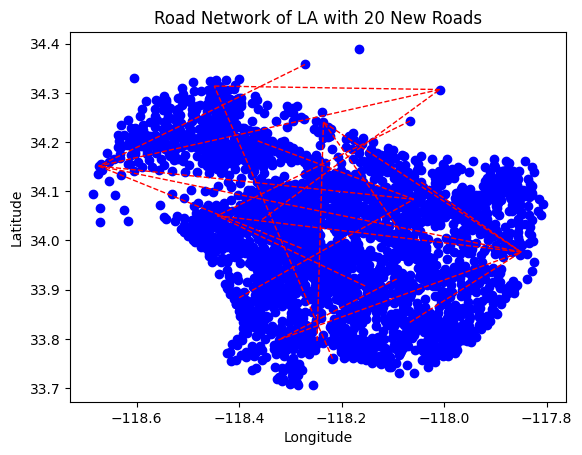

NameError: ignored

In [ ]:
from operator import index
import heapq
import math
import numpy as np
import igraph as ig
from itertools import combinations
from operator import itemgetter

def calculate_euclidean_distance(v1, v2):
    return np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)

def dijkstra(graph, source, new_edges_2):
    distances = {}  # Dictionary to store the shortest distances
    extra_distances_21 = {}  # Dictionary to store the extra
    max_extra_distance = 0  # Variable to track the maximum extra
    max_extra_distance_nodes = None  # Variables to store the nodes with maximum extra
    visited = set()

    # Initialize distances and extra times
    vertices = graph.vs.indices
    for node in vertices:
        distances[node] = float('inf')
        extra_distances_21[node] = 0
    distances[source] = 0

    # Priority queue to store the nodes and their distances
    priority_queue = [(0, source)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        visited.add(current_node)

        # Check if current_distance exceeds the current maximum extra distance
        if extra_distances_21[current_node] > max_extra_distance:
            max_extra_distance = extra_distances_21[current_node]
            max_extra_distance_nodes = (source, current_node)

        # Explore neighboring nodes
        for neighbor in graph.vs[current_node].neighbors():
            if not (neighbor in visited) and not ((source, neighbor) in new_edges_2):
                neighbor = neighbor.index
                edge_attrs = graph.es[graph.get_eid(current_node,neighbor)].attributes()
                distance = edge_attrs['weight']
                new_distance = distances[current_node] + distance
                euc_dist = calculate_euclidean_distance(graph.vs[source], graph.vs[neighbor])
                new_extra_distance = new_distance - euc_dist
                # if(source == 2704 and neighbor == 2072):
                #     print(distance, shortest_distance, new_extra_distance, new_distance, euc_dist, edge_attrs)
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    heapq.heappush(priority_queue, (new_distance, neighbor))
                    if new_extra_distance > extra_distances_21[neighbor]:
                        extra_distances_21[neighbor] = new_extra_distance

    return max_extra_distance_nodes, extra_distances_21


new_edges = []
new_edges_2 = []
for q in range(20):
    print(q)
    max_extra_distance = 0
    max_extra_distance_nodes = None

    vertices = g_temp_3.vs.indices
    L = len(vertices)
    for k, source in enumerate(vertices):
        print("\r", str(round((k / L)*100,2)) + "%", end="")
        nodes, extra_distances_21 = dijkstra(g_temp_3, source, new_edges_2)
        # if(nodes == (2704, 2072)):

        #   print(max_extra_distance, extra_distances_21[nodes[1]], nodes, source)
        if nodes is not None and extra_distances_21[nodes[1]] > max_extra_distance:
            max_extra_distance = extra_distances_21[nodes[1]]
            max_extra_distance_nodes = nodes
    print()
    new_edges_2.append(max_extra_distance_nodes)
    v1, v2 = max_extra_distance_nodes
    source = g_temp_3.vs[v1]
    destination = g_temp_3.vs[v2]

    new_edges.append((v1, v2, max_extra_distance))
    distance = calculate_euclidean_distance(source,destination)
    g_temp_3.add_edge(v1, v2, weight=distance)

    lat1 = source['lat']
    lon1 = source['lon']
    lat2 = destination['lat']
    lon2 = destination['lon']
    print(f"Extra distance: {max_extra_distance}")
    print(f"Source: {v1}, ({np.round(lat1,5)}, {np.round(lon1,5)}), Target: {v2}, ({np.round(lat2,5)}, {np.round(lon2,5)})")

# Plot
plt.scatter(lon, lat, color='blue', label='Existing Nodes')
for pair in new_edges:
    v1 = pair[0]
    v2 = pair[1]
    plt.plot([lon[v1], lon[v2]], [lat[v1], lat[v2]], color='red', linestyle='dashed',linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network of LA with 20 New Roads')
plt.show()

print(distance, shortest_distance, new_extra_distance, new_distance, euc_dist, edge_attrs)

print(max_extra_distance, extra_distances_21[nodes[1]], nodes, source)

## QUESTION 22

In [ ]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [ ]:
g_22 = Graph(directed=False)
g_22.add_vertices(len(display_names))
g_22.vs['display_name'] = list(display_names.values())  # index = id - 1
g_22.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open(file_time) as f:
    f.readline()  # skip the first line

    while True:
        line = f.readline()
        if line == '':
            break  # end of file

        vals = line.strip().split(',')

        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue

        edges.append((src - 1, dest - 1))
        weights.append(dist)

g_22.add_edges(edges)
g_22.es['weight'] = weights
del edges, weights

# keep only the giant connected component
components = g_22.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g_22.vs)) if i not in gcc]
g_22.delete_vertices(vs_to_delete)

# remove duplicate edges
g_22 = g_22.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [ ]:
import igraph as ig

g_temp_4 = ig.Graph()
g_temp_4.add_vertices(len(delaunay_out.points))

g_temp_4.vs['lat'] = lat
g_temp_4.vs['lon'] = lon

fake_edges = set()

# Add edges to the graph based on coordinate threshold
coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence
for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp_4.vs[edge[0]]
        v2 = g_temp_4.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp_4.add_edge(edge[0], edge[1], weight=distance)
        else:
            fake_edges.add(edge)


for ind in fake_edges:
  g_temp_4.delete_edges(ind)

In [ ]:
edges_g_22 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_22.es])
edges_g_temp_4 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_temp_4.es])

if edges_g_22 == edges_g_temp_4:
    print("The edges have the same vertices for g_22 and g_temp_4.")
else:
    missing_edges_g_22 = sorted(list(set(edges_g_temp_4) - set(edges_g_22)))
    missing_edges_g_temp_4 = sorted(list(set(edges_g_22) - set(edges_g_temp_4)))

    if missing_edges_g_22:
        print("Edges in g_temp_4 that are missing in g_22:")
        for edge in missing_edges_g_22:
            print(f"Source: {edge[0]}, Target: {edge[1]}")
            # e2_id = g_temp_4.get_eid(edge[0],edge[1])
            # g_temp_4.delete_edges(e2_id)
            e2_id = g_temp_4.get_eid(edge[1],edge[0])
            g_temp_4.delete_edges(e2_id)
edges_g_temp_4 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_temp_4.es])

if edges_g_22 == edges_g_temp_4:
    print("The edges have the same vertices for g_22 and g_temp_4.")
else:
    missing_edges_g_22 = sorted(list(set(edges_g_temp_4) - set(edges_g_22)))
    missing_edges_g_temp_4 = sorted(list(set(edges_g_22) - set(edges_g_temp_4)))

    if missing_edges_g_22:
        print("Edges in g_temp_4 that are missing in g_22:")
        for edge in missing_edges_g_22:
            print(f"Source: {edge[0]}, Target: {edge[1]}")
            # e2_id = g_temp_4.get_eid(edge[0],edge[1])
            # g_temp_4.delete_edges(e2_id)
            e2_id = g_temp_4.get_eid(edge[1],edge[0])
            g_temp_4.delete_edges(e2_id)
edges_g_temp_4 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_temp_4.es])

if edges_g_22 == edges_g_temp_4:
    print("The edges have the same vertices for g_22 and g_temp_4.")
else:
    missing_edges_g_22 = sorted(list(set(edges_g_temp_4) - set(edges_g_22)))
    missing_edges_g_temp_4 = sorted(list(set(edges_g_22) - set(edges_g_temp_4)))

    if missing_edges_g_22:
        print("Edges in g_temp_4 that are missing in g_22:")
        for edge in missing_edges_g_22:
            print(f"Source: {edge[0]}, Target: {edge[1]}")
            # e2_id = g_temp_4.get_eid(edge[0],edge[1])
            # g_temp_4.delete_edges(e2_id)
            e2_id = g_temp_4.get_eid(edge[1],edge[0])
            g_temp_4.delete_edges(e2_id)
    # if missing_edges_g_temp_4:
    #     print("Edges in g_22 that are missing in g_temp_4:")
    #     for edge in missing_edges_g_temp_4:
    #         print(f"Source: {edge[0]}, Target: {edge[1]}")


In [ ]:
# Create the combined graph with both time and distance weights
combined_graph = g_temp_4.copy()

for e in g_temp_4.es():
    v1 = e.source
    v2 = e.target
    distance_weight = e['weight']
    try:
      e2_id = g_22.get_eid(v1, v2)
    except Exception as exception:
      print(exception)
      e2_id = g_22.get_eid(v2, v1)
    e2 = g_22.es[e2_id]
    time_weight = e2['weight']

    combined_graph.es[e.index]['distance'] = distance_weight
    combined_graph.es[e.index]['time'] = time_weight

In [ ]:
temp_graph = combined_graph.copy()

In [ ]:
combined_graph = temp_graph.copy()

 0.07%, 230.785

C:\Users\Chris\AppData\Local\Temp\ipykernel_27564\1980788287.py:12: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:524
  path = combined_graph.get_shortest_paths(v1.index, v2.index, weights='weight')[0]


 100.0%, 32.7325.9%, 446.7913.67%, 106.0218.93%, 76.6618.95%, 183.8931.96%, 256.5933.64%, 272.238.25%, 190.2944.6%, 349.6644.78%, 73.4657.68%, 345.3158.7%, 263.459.63%, 355.3759.81%, 344.461.2%, 345.5364.77%, 164.3468.09%, 292.3472.36%, 261.1373.68%, 342.1776.17%, 292.31Source: 383, Destination: 2418, Weight: 3357.0025507795463
Source: 2140, Destination: 2418, Weight: 3355.6416018500495
Source: 382, Destination: 2418, Weight: 3304.091506590137
Source: 2150, Destination: 2418, Weight: 3277.056137803833
Source: 2052, Destination: 2418, Weight: 3273.748877816737
Source: 381, Destination: 2418, Weight: 3263.8162518273966
Source: 227, Destination: 2418, Weight: 3242.1538842021546
Source: 386, Destination: 2418, Weight: 3241.3156605416107
Source: 387, Destination: 2418, Weight: 3206.21254844907
Source: 228, Destination: 2418, Weight: 3185.277640401795
Source: 255, Destination: 2418, Weight: 3171.4946210051166
Source: 452, Destination: 2418, Weight: 3149.1216828964716
Source: 257, Destination

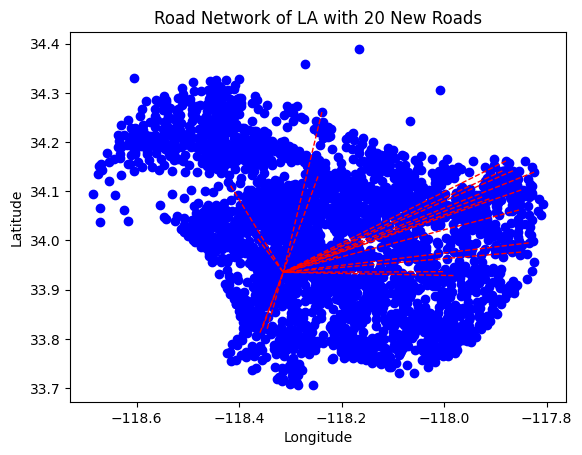

In [ ]:
import math
import numpy as np
import igraph as ig
from itertools import combinations
from operator import itemgetter

def calculate_euclidean_distance(v1, v2):
    return np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)

def calculate_travel_speed(v1, v2):
    # Calculate the shortest path
    path = combined_graph.get_shortest_paths(v1.index, v2.index, weights='weight')[0]

    # for each vertice, add the weights of time and distance
    shortest_distance = 0
    shortest_time = 0
    for i in range(len(path)-1):
        edge = combined_graph.es.find(_source=path[i], _target=path[i+1])
        shortest_time += edge['time']
        shortest_distance += edge['distance']

    if shortest_time == 0:
        shortest_time += 0.000000001
    if shortest_distance == 0:
        shortest_distance += 0.000000001

    return (shortest_distance / shortest_time, shortest_time)

def calculate_extra_time(v1, v2):
    euclidean_distance = calculate_euclidean_distance(v1, v2)
    travel_speed, shortest_time = calculate_travel_speed(v1, v2)
    return shortest_time - (euclidean_distance / travel_speed)

# Calculate extra time between all pairs of points
extra_times = []
extra_time = 0
vertices = combined_graph.vs()
L = math.comb(len(vertices), 2)
for k, pair in enumerate(combinations(vertices, 2)):
    print("\r", str(round((k / L)*100,2)) + "%, " + str(round(extra_time,2)), end="")
    v1,v2 = pair
    extra_time = calculate_extra_time(v1, v2)
    extra_times.append((v1.index, v2.index, extra_time))

# Sort the extra times in descending order
extra_times_sorted = extra_times.copy()
extra_times_sorted.sort(key=itemgetter(2), reverse=True)

# Get the top 20 pairs with highest extra time
top_pairs = extra_times_sorted[:20]

# Plot
plt.scatter(lon, lat, color='blue', label='Existing Nodes')

# Print the source and destination of the top pairs
for pair in top_pairs:
    v1 = pair[0]
    v2 = pair[1]
    print(f"Source: {v1}, Destination: {v2}, Weight: {pair[2]}")
    combined_graph.add_edge(v1, v2)
    plt.plot([lon[v1], lon[v2]], [lat[v1], lat[v2]], color='red', linestyle='dashed',linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network of LA with 20 New Roads')
plt.show()

## QUESTION 23:

In [ ]:
import igraph as ig
g_temp_5 = ig.Graph()
g_temp_5.add_vertices(len(delaunay_out.points))

g_temp_5.vs['lat'] = lat
g_temp_5.vs['lon'] = lon


# Add edges to the graph based on coordinate threshold
coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence
for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp_5.vs[edge[0]]
        v2 = g_temp_5.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp_5.add_edge(edge[0], edge[1], weight=distance)


In [ ]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

g_23 = Graph(directed=False)
g_23.add_vertices(len(display_names))
g_23.vs['display_name'] = list(display_names.values())  # index = id - 1
g_23.vs['coordinates'] = list(coordinates.values())

edges = []
weights = []

with open(file_time) as f:
    f.readline()  # skip the first line

    while True:
        line = f.readline()
        if line == '':
            break  # end of file

        vals = line.strip().split(',')

        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        edges.append((src-1, dest-1))
        weights.append(dist)

g_23.add_edges(edges)
g_23.es['weight'] = weights
del edges, weights

In [ ]:
edges_g_23 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_23.es])
edges_g_temp_5 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_temp_5.es])

if edges_g_23 == edges_g_temp_5:
    print("The edges have the same vertices for g_23 and g_temp_5.")
else:
    missing_edges_g_23 = sorted(list(set(edges_g_temp_5) - set(edges_g_23)))
    missing_edges_g_temp_5 = sorted(list(set(edges_g_23) - set(edges_g_temp_5)))

    if missing_edges_g_23:
        print("Edges in g_temp_5 that are missing in g_23:")
        for edge in missing_edges_g_23:
            print(f"Source: {edge[0]}, Target: {edge[1]}")
            # e2_id = g_temp_5.get_eid(edge[0],edge[1])
            # g_temp_5.delete_edges(e2_id)
            e2_id = g_temp_5.get_eid(edge[1],edge[0])
            g_temp_5.delete_edges(e2_id)
edges_g_temp_5 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_temp_5.es])

if edges_g_23 == edges_g_temp_5:
    print("The edges have the same vertices for g_23 and g_temp_5.")
else:
    missing_edges_g_23 = sorted(list(set(edges_g_temp_5) - set(edges_g_23)))
    missing_edges_g_temp_5 = sorted(list(set(edges_g_23) - set(edges_g_temp_5)))

    if missing_edges_g_23:
        print("Edges in g_temp_5 that are missing in g_23:")
        for edge in missing_edges_g_23:
            print(f"Source: {edge[0]}, Target: {edge[1]}")
            # e2_id = g_temp_5.get_eid(edge[0],edge[1])
            # g_temp_5.delete_edges(e2_id)
            e2_id = g_temp_5.get_eid(edge[1],edge[0])
            g_temp_5.delete_edges(e2_id)
edges_g_temp_5 = sorted([tuple(sorted((edge.source, edge.target))) for edge in g_temp_5.es])

if edges_g_23 == edges_g_temp_5:
    print("The edges have the same vertices for g_23 and g_temp_5.")
else:
    missing_edges_g_23 = sorted(list(set(edges_g_temp_5) - set(edges_g_23)))
    missing_edges_g_temp_5 = sorted(list(set(edges_g_23) - set(edges_g_temp_5)))

    if missing_edges_g_23:
        print("Edges in g_temp_5 that are missing in g_23:")
        for edge in missing_edges_g_23:
            print(f"Source: {edge[0]}, Target: {edge[1]}")
            # e2_id = g_temp_5.get_eid(edge[0],edge[1])
            # g_temp_5.delete_edges(e2_id)
            e2_id = g_temp_5.get_eid(edge[1],edge[0])
            g_temp_5.delete_edges(e2_id)
    # if missing_edges_g_temp_5:
    #     print("Edges in g_23 that are missing in g_temp_5:")
    #     for edge in missing_edges_g_temp_5:
    #         print(f"Source: {edge[0]}, Target: {edge[1]}")


Edges in g_temp_5 that are missing in g_23:
Source: 13, Target: 1934
Source: 14, Target: 1934
Source: 15, Target: 1934
Source: 22, Target: 2472
Source: 41, Target: 2165
Source: 42, Target: 56
Source: 42, Target: 2165
Source: 43, Target: 56
Source: 43, Target: 386
Source: 43, Target: 2165
Source: 53, Target: 509
Source: 56, Target: 286
Source: 56, Target: 386
Source: 56, Target: 2165
Source: 56, Target: 2474
Source: 58, Target: 456
Source: 59, Target: 456
Source: 67, Target: 509
Source: 122, Target: 1690
Source: 123, Target: 1690
Source: 124, Target: 1690
Source: 149, Target: 1676
Source: 184, Target: 1722
Source: 184, Target: 2059
Source: 286, Target: 2252
Source: 286, Target: 2474
Source: 322, Target: 2476
Source: 322, Target: 2477
Source: 323, Target: 2477
Source: 325, Target: 2435
Source: 325, Target: 2477
Source: 341, Target: 382
Source: 382, Target: 517
Source: 382, Target: 699
Source: 382, Target: 700
Source: 382, Target: 1695
Source: 382, Target: 2159
Source: 382, Target: 2270
S

In [ ]:
# Create the combined graph with both time and distance weights
combined_graph_2 = g_temp_5.copy()

for e in g_temp_5.es():
    v1 = e.source
    v2 = e.target
    distance_weight = e['weight']
    try:
      e2_id = g_23.get_eid(v1, v2)
    except Exception as exception:
      print(exception)
      e2_id = g_23.get_eid(v2, v1)
    e2 = g_23.es[e2_id]
    time_weight = e2['weight']

    combined_graph_2.es[e.index]['distance'] = distance_weight
    combined_graph_2.es[e.index]['time'] = time_weight

In [ ]:
tmp_graph = combined_graph_2.copy()

In [ ]:
combined_graph_2 = tmp_graph.copy()

0
 99.96%
Extra time: 8121.110982022266
Source: 2474, (34.30688, -118.00883), Target: 2172, (33.99312, -117.86674)
1
 99.96%
Extra time: 7479.3868365959215
Source: 2472, (34.24297, -118.06648), Target: 22, (34.16642, -118.02459)
2
 99.96%
Extra time: 4547.485146587284
Source: 407, (33.92764, -118.35711), Target: 2474, (34.30688, -118.00883)
3
 99.96%
Extra time: 9161.952603010608
Source: 706, (34.27414, -118.30694), Target: 2474, (34.30688, -118.00883)
4
 99.96%
Extra time: 7236.379047411423
Source: 1745, (34.02517, -118.13506), Target: 2474, (34.30688, -118.00883)
5
 99.96%
Extra time: 6639.528210030359
Source: 2113, (34.02738, -118.05471), Target: 407, (33.92764, -118.35711)
6
 99.96%
Extra time: 6229.230118526808
Source: 698, (34.25076, -118.29106), Target: 407, (33.92764, -118.35711)
7
 99.96%
Extra time: 6478.681108317709
Source: 1163, (34.08095, -118.28263), Target: 698, (34.25076, -118.29106)
8
 99.96%
Extra time: 6357.43799406245
Source: 1144, (34.10254, -118.37758), Target: 40

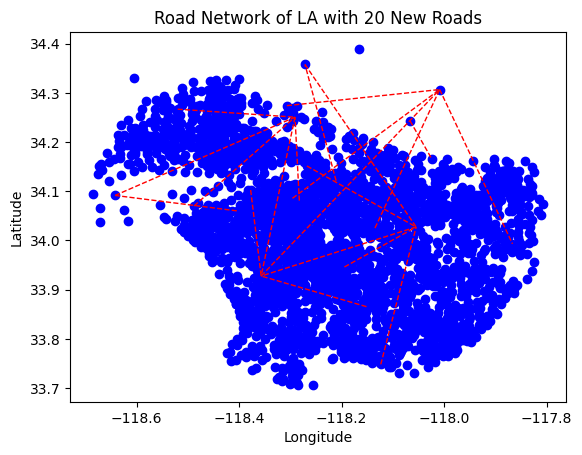

In [ ]:
from operator import index
import heapq
import math
import numpy as np
import igraph as ig
from itertools import combinations
from operator import itemgetter

def calculate_euclidean_distance(v1, v2):
    return np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)

def calculate_travel_speed(v1, v2):
    # Calculate the shortest path
    path = combined_graph_2.get_shortest_paths(v1, v2, weights='weight')[0]

    # for each vertice, add the weights of time and distance
    shortest_distance = 0
    shortest_time = 0
    for i in range(len(path)-1):
        edge = combined_graph_2.es.find(_source=path[i], _target=path[i+1])
        shortest_time += edge['time']
        shortest_distance += edge['distance']

    if shortest_time == 0:
        shortest_time += 0.000000001
    if shortest_distance == 0:
        shortest_distance += 0.000000001

    return (shortest_distance / shortest_time)

def dijkstra(graph, source, new_edges_2):
    distances = {}  # Dictionary to store the shortest distances
    times = {} # dictionary of shortest times
    extra_times_23 = {}  # Dictionary to store the extra times
    max_extra_time = 0  # Variable to track the maximum extra time
    max_extra_time_nodes = None  # Variables to store the nodes with maximum extra time
    visited = set()

    # Initialize distances and extra times
    vertices = graph.vs.indices
    for node in vertices:
        times[node] = 0
        distances[node] = float('inf')
        extra_times_23[node] = 0
    distances[source] = 0

    # Priority queue to store the nodes and their distances
    priority_queue = [(0, source)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        visited.add(current_node)

        # Check if current_distance exceeds the current maximum extra time
        if extra_times_23[current_node] > max_extra_time:
            max_extra_time = extra_times_23[current_node]
            max_extra_time_nodes = (source, current_node)

        # Explore neighboring nodes
        for neighbor in graph.vs[current_node].neighbors():
            # Skip if the node has been visited before
            if neighbor in visited:
                continue
            neighbor = neighbor.index
            edge_attrs = graph.es[graph.get_eid(current_node,neighbor)].attributes()
            distance = edge_attrs['distance']
            time = edge_attrs['time']
            new_time = times[current_node] + time
            new_distance = distances[current_node] + distance
            euc_dist = calculate_euclidean_distance(graph.vs[source], graph.vs[neighbor])
            if(new_time == 0):
                new_time += 0.000000001
            if(new_distance == 0):
                new_distance += 0.00000001
            new_extra_time = new_time - ( euc_dist / (new_distance / new_time) )

            if new_distance < distances[neighbor]:
                if new_extra_time > extra_times_23[neighbor]:
                    extra_times_23[neighbor] = new_extra_time
                distances[neighbor] = new_distance
                times[neighbor] = new_time
                heapq.heappush(priority_queue, (new_distance, neighbor))

    return max_extra_time_nodes, extra_times_23


new_edges = []
new_edges_2 = []
for q in range(20):
    print(q)
    max_extra_time = 0
    max_extra_time_nodes = None

    vertices = combined_graph_2.vs.indices
    L = len(vertices)
    for k, source in enumerate(vertices):
        print("\r", str(round((k / L)*100,2)) + "%", end="")
        nodes, extra_times_23 = dijkstra(combined_graph_2, source, new_edges_2)
        if nodes is not None and extra_times_23[nodes[1]] > max_extra_time:
            max_extra_time = extra_times_23[nodes[1]]
            max_extra_time_nodes = nodes
    print()

    v1, v2 = max_extra_time_nodes
    source = combined_graph_2.vs[v1]
    destination = combined_graph_2.vs[v2]
    new_edges_2.append(max_extra_time_nodes)

    new_edges.append((v1, v2, max_extra_time))
    distance = calculate_euclidean_distance(source,destination)
    time_weight = distance / calculate_travel_speed(v1,v2)

    combined_graph_2.add_edge(v1, v2, weight=distance, distance=distance, time=time_weight)

    lat1 = source['lat']
    lon1 = source['lon']
    lat2 = destination['lat']
    lon2 = destination['lon']
    print(f"Extra time: {max_extra_time}")
    print(f"Source: {v1}, ({np.round(lat1,5)}, {np.round(lon1,5)}), Target: {v2}, ({np.round(lat2,5)}, {np.round(lon2,5)})")

# Plot
plt.scatter(lon, lat, color='blue', label='Existing Nodes')
for pair in new_edges:
    v1 = pair[0]
    v2 = pair[1]
    plt.plot([lon[v1], lon[v2]], [lat[v1], lat[v2]], color='red', linestyle='dashed',linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network of LA with 20 New Roads')
plt.show()